In [1]:
pip install pandas numpy opencv-python pillow matplotlib visualkeras pennylane tensorflow==2.12.0

  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
  Using cached pillow-11.1.0-cp310-cp310-win_amd64.whl (2.6 MB)
  Using cached matplotlib-3.10.1-cp310-cp310-win_amd64.whl (8.1 MB)
  Using cached visualkeras-0.1.4-py3-none-any.whl (17 kB)
  Using cached PennyLane-0.40.0-py3-none-any.whl (2.0 MB)
  Using cached tensorflow-2.12.0-cp310-cp310-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp310-cp310-win_amd64.whl (272.8 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
  Using cached fonttools-4.56.0-cp310-cp310-win_amd64.whl (2.2 MB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl (71 kB)
  Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl (218 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached aggdraw-1.3.19-cp310-cp310-win_amd64.whl (44 kB)
  Using cached appdirs-1.4.4-py2.py3-no

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\mello_onii\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
pip show tensorflow

Name: tensorflowNote: you may need to restart the kernel to use updated packages.

Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\mello_onii\appdata\local\programs\python\python310\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [4]:
import os
import random

import pandas as pd
from collections import Counter
from timeit import default_timer as timer

import keras
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D ,Dropout


import visualkeras

In [5]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

all_0 = "C-NMC_Leukemia/training_data/fold_0/all"
all_1 = "C-NMC_Leukemia/training_data/fold_1/all"
all_2 = "C-NMC_Leukemia/training_data/fold_2/all"

hem_0 = "C-NMC_Leukemia/training_data/fold_0/hem"
hem_1 = "C-NMC_Leukemia/training_data/fold_1/hem"
hem_2 = "C-NMC_Leukemia/training_data/fold_2/hem"
path_val ='C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data'
val_labels = pd.read_csv('C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

#image absolute paths for cancer cells and normal cells
cancer_lst = []

for i in [all_0,all_1,all_2]:
    paths = get_path_image(i)
    cancer_lst.extend(paths)
print('No. of cancer images:', len(cancer_lst))

normal_lst = []
for i in [hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    normal_lst.extend(paths)
print('No. of normal images:', len(normal_lst))


cancer_dict = {"x_col":cancer_lst, "y_col":[np.nan for x in range(len(cancer_lst))]}
cancer_dict["y_col"] = "ALL"

normal_dict = {"x_col":normal_lst, "y_col":[np.nan for x in range(len(normal_lst))]}
normal_dict["y_col"] = "HEM"


cancer_df = pd.DataFrame(cancer_dict)
normal_df = pd.DataFrame(normal_dict)

select_normal = np.random.choice(normal_lst, 3, replace = False)
select_all = np.random.choice(cancer_lst, 3, replace = False)

train_df = pd.concat([cancer_df, normal_df], ignore_index=True)

validation_list = get_path_image(path_val)
#0 - нормальные клетки, 1 - раковые

validation_dict = {"x_col":validation_list ,"y_col":val_labels["labels"]}
validation_df = pd.DataFrame(validation_dict)
validation_df["y_col"].replace(to_replace = [1,0], value = ["ALL","HEM"], inplace = True)


# Code Resizig For teating data
test_data = 'C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
test_list = get_path_image(test_data)

test_dict = {"x_col":test_list}

test_df = pd.DataFrame(test_dict)

size = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
                  train_df,
                  x_col = "x_col",
                  y_col = "y_col",
                  target_size = (size, size),
                 
                  batch_size = 32,
                  color_mode = "rgb",
                  shuffle = True,
                  class_mode = "binary"
)

val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_dataframe(
                  validation_df,
                  x_col = "x_col",
                  y_col = "y_col",
                  target_size = (size, size),                  
                  batch_size = 32,
                  color_mode = "rgb",
                  shuffle = True,
                  class_mode = "binary")


test_datagen = ImageDataGenerator(rescale=1./255 )
test_generator = test_datagen.flow_from_dataframe(
                  test_df,
                  x_col = "x_col",
                  target_size = (size, size),
                  color_mode = "rgb",
                  class_mode = None,
                  shuffle = False
)

No. of cancer images: 7272
No. of normal images: 3389


C:\Users\mello_onii\AppData\Local\Temp\ipykernel_11140\2366310130.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  validation_df["y_col"].replace(to_replace = [1,0], value = ["ALL","HEM"], inplace = True)


Found 10661 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.
Found 2586 validated image filenames.


In [28]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits,
    dtype=tensorflow.float32  # Указываем тип выхода
)

In [29]:
model = tensorflow.keras.models.Sequential([
    layers.ZeroPadding2D(padding=(2, 2), input_shape=(size, size, 3)),
    layers.Conv2D(30, (5, 5), strides=1, padding="valid", activation='relu'),
    layers.Dropout(0.4),
    
    layers.ZeroPadding2D(padding=(2, 2)),
    layers.Conv2D(30, (5, 5), strides=1, padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    layers.Dropout(0.6),
    
    layers.Flatten(),
    layers.Dense(n_qubits, activation='relu'),
    # Квантовый слой с преобразованием типа
    tensorflow.keras.layers.Lambda(lambda x: tensorflow.cast(x, tensorflow.complex64)),  # Явное преобразование
    qlayer,
    # Преобразование комплексных чисел в вещественные
    tensorflow.keras.layers.Lambda(lambda x: tensorflow.math.real(x)),  # Извлекаем вещественную часть
    layers.Dense(1, activation='sigmoid')
])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_6 (ZeroPaddi  (None, 228, 228, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 30)      2280      
                                                                 
 dropout_6 (Dropout)         (None, 224, 224, 30)      0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 228, 228, 30)     0         
 ng2D)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 30)      22530     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 30)    

In [31]:
# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
start = timer()
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, 
                    class_weight={0: 0.73, 1: 1.57})
end = timer()

elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/20
 10/334 [..............................] - ETA: 23:43 - loss: 0.6657 - accuracy: 0.5562

KeyboardInterrupt: 

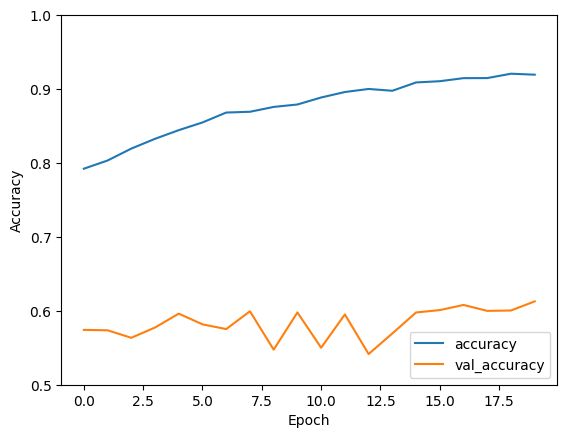

In [ ]:
# График точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('model_q.h5')

c:\Users\mello_onii\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


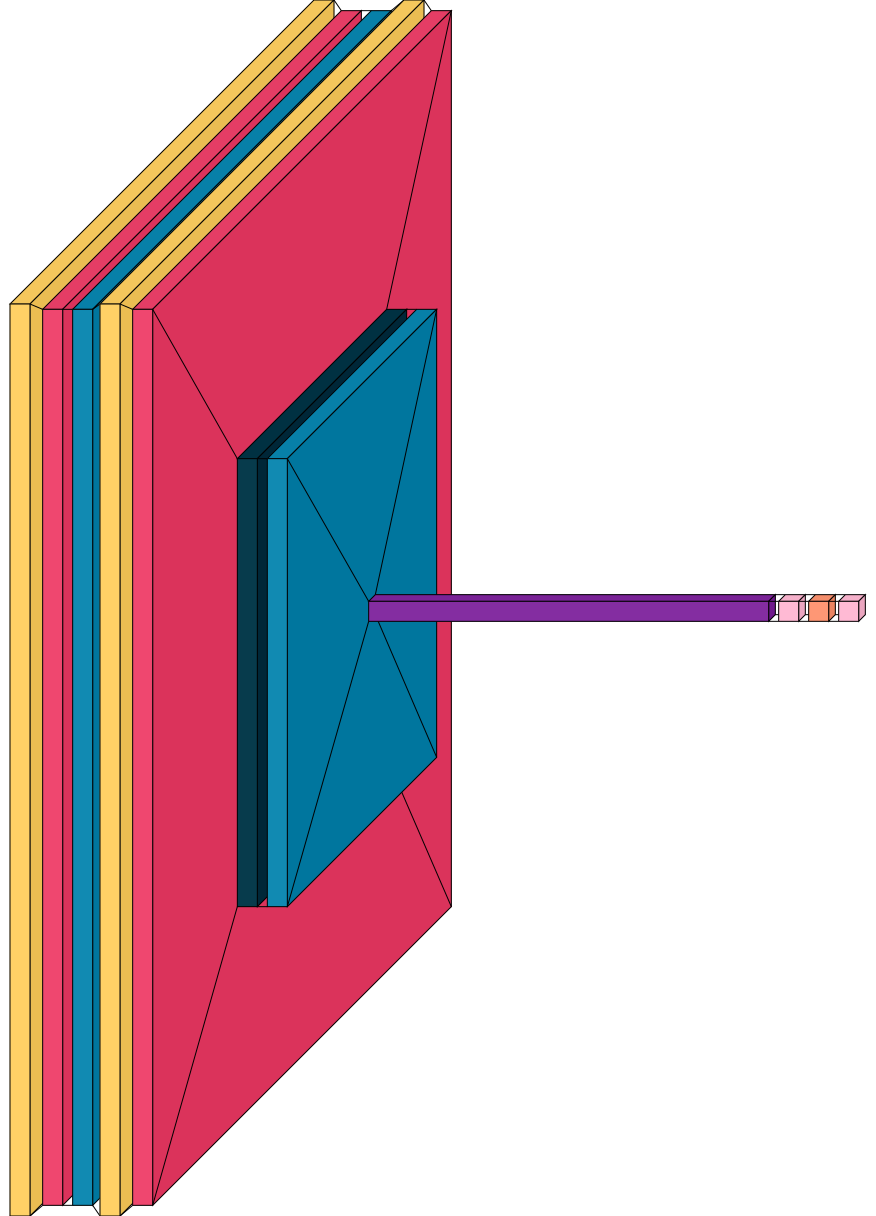

In [368]:
visualkeras.layered_view(model)

In [261]:
def testing(image_path):
    test_image = image.load_img(image_path,target_size=(size,size))
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis=0)
    result = model.predict(test_image)
    print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
[[0.]]


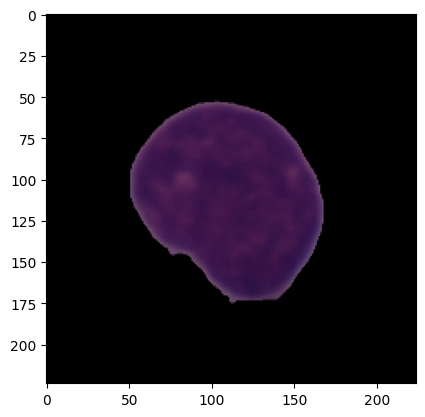

In [262]:
image_path = 'C-NMC_Leukemia/training_data/fold_0/all/UID_1_6_1_all.bmp'
testing(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.]]


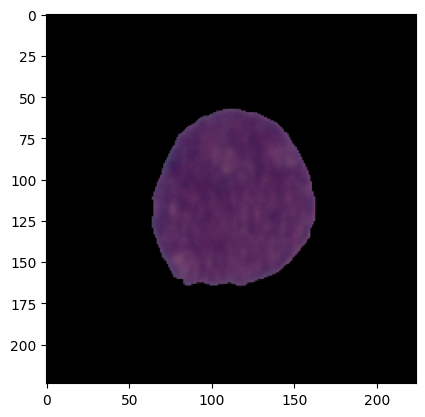

In [263]:
image_path = 'C-NMC_Leukemia/training_data/fold_2/all/UID_78_9_4_all.bmp'
testing(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[1.]]


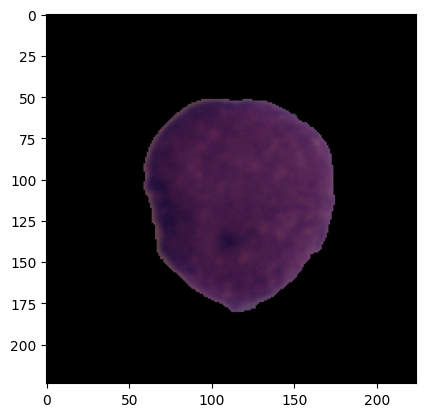

In [264]:
image_path = 'C-NMC_Leukemia/training_data/fold_0/hem/UID_H6_1_2_hem.bmp'
testing(image_path)